In [1]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time, warnings
from datetime import datetime #DB

import gc #DB
from config import fcn_config as cfg
from config import fcn8_cnn as cnn
from sklearn.utils import shuffle
from config import unet as unet #DB

import pandas as pd
warnings.filterwarnings("ignore")

fcn_config.py runs from  /workspace/Vitis-AI-Tutorials-2.5/Tutorials/Keras_FCN8_UNET_segmentation/files/code


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras.backend               import set_session
from tensorflow.keras                       import backend
from tensorflow.keras.utils                 import plot_model #DB
from tensorflow.keras.preprocessing.image   import ImageDataGenerator #DB
from tensorflow.keras.models                import *
from tensorflow.keras.layers                import *
from tensorflow.keras.optimizers            import RMSprop, SGD


In [4]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
#config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
set_session(tf.compat.v1.Session(config=config))


In [7]:

HEIGHT = cfg.HEIGHT
WIDTH  = cfg.WIDTH
N_CLASSES = cfg.NUM_CLASSES

BATCH_SIZE = cfg.BATCH_SIZE
EPOCHS = cfg.EPOCHS

In [5]:
dir_data = cfg.DATASET_DIR
dir_train_img = cfg.dir_train_img
dir_train_seg = cfg.dir_train_seg
dir_test_img  = cfg.dir_test_img
dir_test_seg  = cfg.dir_test_seg
dir_calib_img = cfg.dir_calib_img
dir_calib_seg = cfg.dir_calib_seg
dir_valid_img = cfg.dir_valid_img
dir_valid_seg = cfg.dir_valid_seg



In [10]:
model_type=2

In [8]:
model = unet.UNET_v2(N_CLASSES, HEIGHT, WIDTH)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

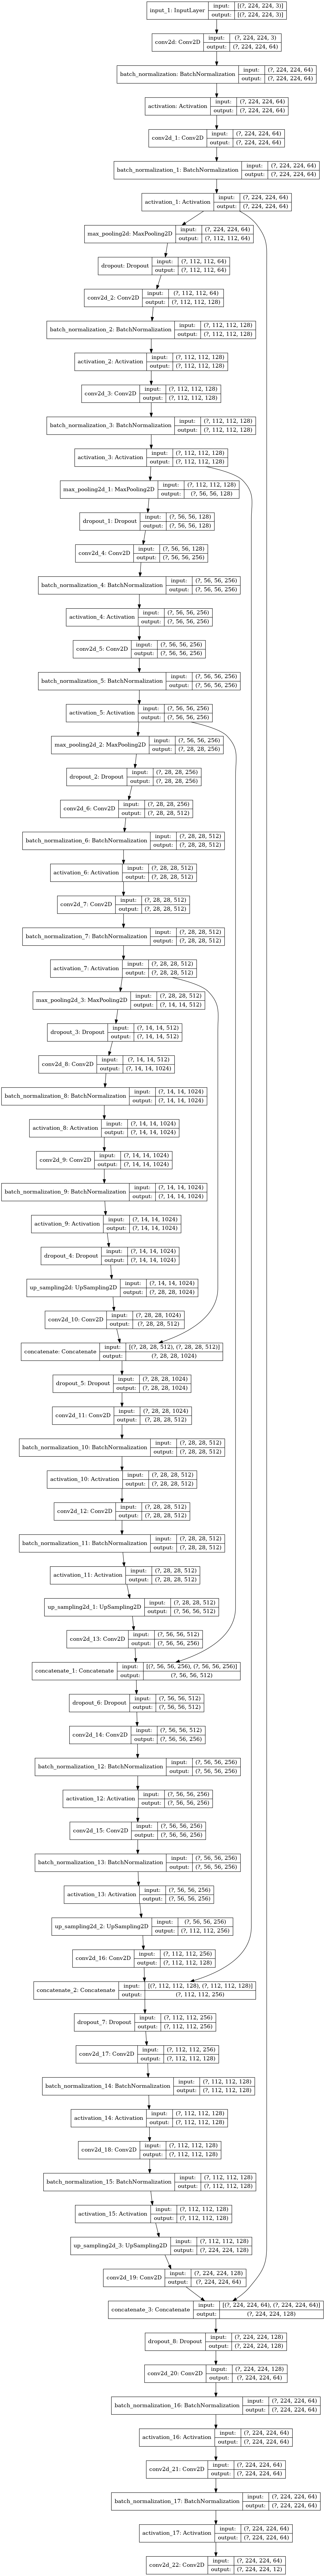

In [11]:
model.summary()

# plot the CNN model
plot_model(model, to_file="../rpt/unet_model" +str(model_type) + "_"  + str(WIDTH) + "x" + str(HEIGHT) + ".png", show_shapes=True)

In [12]:

# load training images
train_images = os.listdir(dir_train_img)
train_images.sort()
train_segmentations  = os.listdir(dir_train_seg)
train_segmentations.sort()
X_train = []
Y_train = []

for im , seg in zip(train_images,train_segmentations) :
	X_train.append( cnn.NormalizeImageArr(os.path.join(dir_train_img,im) ))
	Y_train.append( cnn.LoadSegmentationArr( os.path.join(dir_train_seg,seg) , N_CLASSES , WIDTH, HEIGHT)  )

X_train, Y_train = np.array(X_train), np.array(Y_train)
print(X_train.shape,Y_train.shape)


X_train, Y_train = shuffle(X_train, Y_train)

(311, 224, 224, 3) (311, 224, 224, 12)


In [13]:
# load validation images
valid_images = os.listdir(dir_valid_img)
valid_images.sort()
valid_segmentations  = os.listdir(dir_valid_seg)
valid_segmentations.sort()
X_valid = []
Y_valid = []
for im , seg in zip(valid_images,valid_segmentations) :
    X_valid.append( cnn.NormalizeImageArr(os.path.join(dir_valid_img,im)) )
    Y_valid.append( cnn.LoadSegmentationArr( os.path.join(dir_valid_seg,seg) , N_CLASSES , WIDTH, HEIGHT)  )
X_valid, Y_valid = np.array(X_valid) , np.array(Y_valid)
print(X_valid.shape,Y_valid.shape)

X_valid, Y_valid = shuffle(X_valid, Y_valid)


(56, 224, 224, 3) (56, 224, 224, 12)


In [14]:

sgd = SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

callbacks_list = []


In [ ]:

startTime1 = datetime.now() #DB
hist1 = model.fit(X_train,Y_train, validation_data=(X_valid,Y_valid), batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=2)
endTime1 = datetime.now()
diff1 = endTime1 - startTime1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 311 samples, validate on 56 samples
Epoch 1/200
